<a href="https://colab.research.google.com/github/zmess24/personal-website-nextjs/blob/main/transfer_learning_with_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

It's sad to say, but after a month long hiatus, I've officially broken my 2024 goal of publishing an AI blog post every two weeks! In fairness to myself, I've been spending a significant amount of time diving into the world of PyTorch recently, a powerful open-source machine learning library that is used by some of the most pre-eminent AI companies of today for creating powerful deep learning models. My "teacher" in this journey has been Daniel Bourke and his amazing [PyTorch for Deep Learning in 2024](https://zerotomastery.io/courses/learn-pytorch/) online course, which I can confidently say is one of the best deep learning educational resources I've come across. And after about a month of having my nose in the books a few hours everyday, I figured it was time to share a little bit about of what I've been learning!

The topic for this post is going to be my most complex (but hopefully most fun) one yet - using transfer learning to build an image classifier for Los Angeles Laker's players! Transfer learning is a technique that allows us to utilize pre-trained models as a starting point, rather than training a model from scratch. By doing so, we can significantly reduce the computational resources and time required, while still achieving remarkable results.

Transfer learning is particularly useful when dealing with tasks that share similarities with the problem the pre-trained model was originally designed for. In our case, since we're working with image classification (specifcally face detection), we can leverage a model that has been pre-trained on a large dataset of natural images, such as [VGGFace2](https://paperswithcode.com/dataset/vggface2-1).

Let's get right into it!

### Library Imports and Setting Device Agnostic Code

As always, let's import the libraries we will use for the remainder of this post, and as you'll notice, there are quite a few this time. Instead of going through each one in detail, instead I'll just describe the core ones that we will use to the bulk of the heavy lifting.

* `torch`: Also known as PyTorch, this is a popular open-source machine learning library used for developing and training neural network models. It provides a wide range of tools and libraries for deep learning, and it's known for its flexibility and ease of use.
*`torchvision`: A companion library to PyTorch that provides utilities for working with image data. It includes pre-trained models, datasets, and common image transformations for computer vision tasks.
* `matplotlib`: A widely used library for creating static, animated, and interactive visualizations in Python. It provides a variety of plotting functions to make graphs and charts, such as line plots, scatter plots, bar charts, and histograms.
* `facenet_pytorch`: A library that provides a PyTorch implementation of the FaceNet model for face detection, recognition, and clustering. It includes pre-trained models and utilities for working with facial recognition tasks.

If you are interested in learning more about the other supplementary libraries, I encourage you to look them up, otherwise you'll see how we use them in the code to come.

*Due to a dependency in the `facenet_pytorch` package (specifically with the `mtcnn` model which we will use as part of our data preprocessing pipeline), we need to use an older version of NumPy in order to resolve a conflict created by the most recent NumPy package.*

In [ ]:
# !pip uninstall numpy -y
!pip install -q numpy==1.21.6
import numpy as np
print(f"NumPy Version: {np.__version__}")

NumPy Version: 1.25.2


In [ ]:
# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

# import PyTorch and Torchvision
import torch
import torchvision

# Image and Visualization Libraries
from PIL import Image
import matplotlib.pyplot as plt

# Pathing Libraries
import os
from pathlib import Path
import zipfile

# Data Typings:
from typing import Dict, List

# Scraping
import requests

# Data Analysis
import mlxtend
import pandas as pd
import random

# Not-Native Google Collab Libraries
try:
  !pip install facenet_pytorch torchinfo -q
  import facenet_pytorch
  from torchinfo import summary
except:
  import facenet_pytorch
  from torchinfo import summary

Let's now create a device variable to enable device-agnostic code execution by leveraging the `torch.cuda.is_available()` method to check if a GPU is accessible on the current system. GPUs have become vital for training modern, high-performance AI models due to their parallel processing capabilities, which allows them to perform computationally intensive mathematical operations significantly faster and more efficiently compared to traditional CPUs. [NVIDIA wrote an insightful article](https://blogs.nvidia.com/blog/why-gpus-are-great-for-ai/#:~:text=The%20net%20result%20is%20GPUs,applications%20that%20use%20accelerated%20computing) that eloquently explains the advantages of GPUs over CPUs for AI workloads, which is well worth reading for a deeper understanding of the underlying technical reasons.


In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

cuda


### Create & Load the Dataset

To kick things off, we need a dataset containing images of Los Angeles Lakers players to train our model. Luckily for us, I've already curated such a dataset, hosted publicly on [GitHub](https://github.com/zmess24/AI_Resources) for easy access and download.

I obtained these player images through web scraping via [Selenium](https://selenium-python.readthedocs.io/getting-started.html) - a popular Python library that provides browser automation tooling. Web scraping itself is a fascinating and nuanced programmatic technique that exists in a moral gray area, and warrants an in-depth discussion of its own. However, since this post's focus is on leveraging transfer learning, I'll refrain from delving into the specifics of my scraping approach. That said, for those interested in exploring the mechanics, I've included annotated code snippets in the appendix of this post.

Let's go ahead and download the player images directly from my GitHub respository by running the below code, which will store the images in a local 'data' folder.

In [ ]:
# Setup data paths
data_path = Path("data/")
download_path = data_path / "lakers_players.zip"

# If the image doesn't exist, download it and prepare it...
if data_path.is_dir():
  print(f"'{data_path}' directory exists. Skipping download.")
else:
  print(f"Did not find {data_path}. Downloading.")
  data_path.mkdir(parents=True, exist_ok=True)

  # Download data
  with open(download_path, "wb") as f:
    url = "https://github.com/zmess24/AI_Resources/raw/main/datasets/lakers_players.zip"
    request = requests.get(url)
    f.write(request.content)

  # Unzip data
  with zipfile.ZipFile(download_path, "r") as zip_ref:
    zip_ref.extractall(data_path)

  print(f"Finished downloading data to {download_path}")

  # Remove .zip file
  os.remove(download_path)

Did not find data. Downloading.
Finished downloading data to data/lakers_players.zip


### Exploratory Data Analysis

With a dataset ready to go, let's perform some initial exploratory data analysis on the images we downloaded by first understanding the root folder structure and what's inside it.

In [ ]:
images_path = Path("data/lakers_players")

for dirpath, dirnames, filenames in os.walk(images_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in {dirpath}")

There are 2 directories and 0 images in data/lakers_players
There are 10 directories and 0 images in data/lakers_players/test
There are 0 directories and 10 images in data/lakers_players/test/Austin Reaves
There are 0 directories and 10 images in data/lakers_players/test/Lebron James
There are 0 directories and 9 images in data/lakers_players/test/Spencer Dinwiddie
There are 0 directories and 10 images in data/lakers_players/test/D_Angelo Russell
There are 0 directories and 10 images in data/lakers_players/test/Rui Hachimura
There are 0 directories and 10 images in data/lakers_players/test/Anthony Davis
There are 0 directories and 10 images in data/lakers_players/test/Tauraen Prince
There are 0 directories and 10 images in data/lakers_players/test/Christian Wood
There are 0 directories and 10 images in data/lakers_players/test/Jaxson Hayes
There are 0 directories and 10 images in data/lakers_players/test/Max Christie
There are 10 directories and 0 images in data/lakers_players/train
Th

At a high level, we can see we have:

* A `train` folder, which contains images we will use for training our model. This folder contains sub-directories with 38-40 images for each player on the Laker's roster.
* A `test` folder, which contains images we will use for validating the accuracy of our model. This folder contains sub-directories with 9-10 images for each player on the Laker's roster.
* A total of 491 images with about ~40 training images and ~10 test images per class or player.

While our dataset is relatively modest compared to renowned image classification benchmarks like VGGFace2 (which contains a staggering 3.31 million images and was used to pre-train the FaceNet CNN we'll later leverage for transfer learning), it provides a viable starting point. Since our objective is to evaluate whether this limited dataset can achieve an acceptable level of accuracy when classifying Lakers roster players from given images, we can always scale up the dataset during the subsequent fine-tuning process to further boost performance if the initial results seem promising.

Now, let's pick a random image from our dataset and visualize it with `matplotlib`. We'll display the image's height, width, and color chanels in addition to the image's label (e.g player name) to give us a full picture (no pun intended) of the different image dimensions.

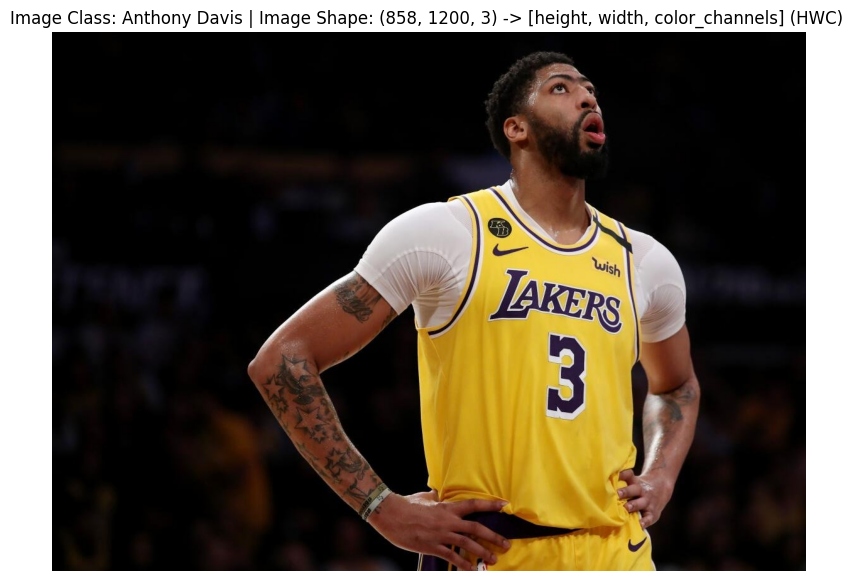

In [ ]:
def pick_random_image(images_path: Path, seed: int = None):
  """
  Picks a random image from a specified directory, displays it, and returns the image.

  The function searches for JPEG images in the specified directory and its subdirectories.
  It then selects a random image, optionally using a provided seed for reproducibility.
  The image class is inferred from the parent directory name, and the image is displayed
  using matplotlib with the image class and shape as the title.

  Parameters:
  - images_path (Path): The path to the directory containing the images.
  - seed (int, optional): An optional seed for the random number generator to ensure reproducibility. Defaults to None.

  Returns:
  - Image: The randomly selected PIL Image object.

  Note: The function assumes that images are stored in a three-level directory structure
  (e.g., "root/class/image.jpg") and are in JPEG format.
  """
  # 1. Get all image paths
  image_path_list = list(images_path.glob("*/*/*.jpg"))

  # 2. Pick a random image with optional seed
  if seed: random.seed(seed)
  random_image_path = random.choice(image_path_list)

  # 3. Get image class from path name (the image class is the name of the directory where the iamge is stored)
  image_class = random_image_path.parent.stem

  # 4. Open the image with PIL and turn into numpy array
  image = Image.open(random_image_path)
  img_array = np.asarray(image)

  # Plot the image with matplotlib
  plt.figure(figsize=(10,7))
  plt.imshow(img_array)
  plt.title(f"Image Class: {image_class} | Image Shape: {img_array.shape} -> [height, width, color_channels] (HWC) ")
  plt.axis(False)

  return image

image = pick_random_image(images_path, seed=None)

### Data Preprocessing

Now that we've completed our initial exploratory data analysis, it's time to get our player images ready for training consumption by performing a little data preprocessing. If you recall from my last [post](https://www.zacmessinger.com/posts/fun-with-linear-algebra-and-matrices), we briefly discussed how neural networks are trained largely through two main mechanisms:

* **Forward Pass**, where dot product multiplication is used to compute the weighted sum for each neuron in a given layer by multiplying the input features values by the vector of the neuron's current weights.
* **Bacwkward Propogation**, where gradient descent is used to calculate the gradient (mathmatically known as a partial derivitive) of a provided loss function with respect to the weights of the network one layer at a time. [I covered a basic example](https://www.zacmessinger.com/posts/gradient-descent-scratch) of how to perform gradient descent using MSE as a loss function back in January.

Given that these key operations are heavily dependent on linear algebra, we cannot directly input our images into a neural network; they must first be converted into tensors. Furthermore, to maximize effectiveness with the FaceNet model we plan to leverage for transfer learning, there are two additional requirements we need to consider based on how the FaceNet model was trained: the images must be 160x160 pixels, and they should be cropped to focus on the players' faces.

So those are our three main data preprocessing goals:

* First, we need to crop each image in our dataset around each players face.
* Second, we need to resize the cropped images to 160x160 pixels.
* Third, we need to convert the cropped and resized images into tensors.

In order to detect, crop, and resize the faces of the players in each image, we're going to use an already pretrained model from the `facenet-pytorch` package called Multi-Task Convolutional Neural Network, or MTCNN for short. If you're interested in learning more about the MTCNN architecture, [this paper](https://paperswithcode.com/paper/joint-face-detection-and-alignment-using) by the authors of the model on Papers with Code covers the intricies of how it works. But for our purposes, it's good enough for now to just know what it's doing and how we can incorporate into our preprocessing pipeline.

The MTCNN model as implemented by `facenet-pytorch` is incredibly versitle in terms of the type of media it can process and the output flexibility it provides (more on that [here](https://www.kaggle.com/code/timesler/guide-to-mtcnn-in-facenet-pytorch)), but we're going to roll with a very straightforward implementation that simply crops a single face from each image, resizes it to 160x160, and then saves it to our local image directory. The fully commented code, which I've wrapped in a function for future re-use, is included below:

In [ ]:
from facenet_pytorch import MTCNN
from torch.utils.data import DataLoader

def crop_faces(data: torchvision.datasets.ImageFolder, batch_size: int, workers: int, device: str):
  """
  Crops faces from images in a dataset using the MTCNN model and saves the cropped faces.

  The function iterates over batches of images from the dataset, detects faces using the MTCNN model,
  and saves the cropped faces to the specified paths. The size of the cropped images is 160x160 pixels,
  which is the size that the InceptionResnetV1 model was trained on.

  Parameters:
  - data (torchvision.datasets.ImageFolder): The dataset containing images to be processed.
  - batch_size (int): The number of images to process in each batch.
  - workers (int): The number of subprocesses to use for data loading.
  - device (str): The device (CPU or GPU) on which the MTCNN model will run.

  Note: The function assumes that the `collate_fn` used in the DataLoader is `training.collate_pil`,
  which is not defined in this code snippet.
  """
  # Set the size of the image crop. InceptionResnetV1 was trained on 160x160 images.
  IMG_SIZE = 160

  # Create an MTCNN model for face detection.
  # - `image_size` specifies the size of the cropped face images.
  # - `margin` is the margin around the detected face.
  # - `thresholds` are the detection thresholds for the three stages of the MTCNN.
  # - `factor` is used to create a scale pyramid of the image.
  # - `post_process` specifies whether to apply post-processing on the detected faces.
  # - `device` specifies the device (CPU or GPU) on which the model will run.
  mtcnn = MTCNN(
    image_size=IMG_SIZE,
    margin=0,
    thresholds=[0.6, 0.7, 0.7],
    factor=0.709,
    post_process=True,
    device=torch.device(device)
  )

  # Create a DataLoader to efficiently load and preprocess batches of images.
  # - `data` is the dataset containing the images.
  # - `num_workers` specifies the number of subprocesses to use for data loading.
  # - `batch_size` specifies the number of images to process in each batch.
  # - `collate_fn` is a function used to merge individual data samples into a batch.
  mtcnn_dataloader = DataLoader(
    data,
    num_workers=workers,
    batch_size=batch_size,
    collate_fn=training.collate_pil
  )

  # Iterate over the DataLoader, processing each batch of images.
  for i, (image, path) in enumerate(mtcnn_dataloader):
    # Detect faces in the batch of images and save the cropped faces to the specified paths.
    mtcnn(image, save_path=path)
    print('\rBatch {} of {}'.format(i + 1, len(mtcnn_dataloader)), end='')

  # Remove the MTCNN model from memory to reduce GPU memory usage.
  del mtcnn

Before we can use the MTCNN model for face detection, we need to organize and load our image dataset. PyTorch provides two helpful classes for this purpose: `ImageFolder` and `DataLoader`.

The [ImageFolder](https://pytorch.org/vision/main/generated/torchvision.datasets.ImageFolder.html) class, commonly used in image classification tasks, provides a convenient way to load image data from a supplied root directory. ImageFolder expects our images to be organized in a specific structure, where each subdirectory in the root directory represents a different image class thereby allowing ImageFodler to automatically assign labels to them. The labels are usually numerical and correspond to the alphabetical order of the class directories.

The [DataLoader](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader) is seperate utility class that allows us to efficiently load, shuffle, and batch our dataset (e.g ImageFolder) during our training. A key parameter here is the batch size, which determines the number of samples to be used in Mini-Batch Gradient Descent, which is the most commonly used variant of Gradient Descent used in neural network training. Generally speaking, a larger batch size can lead to more stable and faster convergence but requires more memory. On the other hand, a smaller batch size can help the model escape local minima and generalize better, but it may lead to slower convergence and more variability in the updates. Since I'm using a single GPU (or, in some cases, a CPU in Google Colab), I've chosen a batch size of 32, which is near the lower limit of recommended batch sizes.

In [ ]:
from torchvision import datasets, transforms
from facenet_pytorch import training

train_dir = './data/lakers_players/train'
test_dir = './data/lakers_players/test'
BATCH_SIZE = 32
WORKERS = 2

# Resize images to 512x512 for consistency given variable image sizes
mtcnn_transform = transforms.Compose([
  transforms.Resize(size=(512, 512))
])

# Create test & train datasets
train_data = datasets.ImageFolder(train_dir, transform=mtcnn_transform, target_transform=None)
test_data = datasets.ImageFolder(test_dir, transform=mtcnn_transform)

train_data.samples = [
    (p, p.replace(train_dir, train_dir + '_cropped'))
        for p, _ in train_data.samples
]

test_data.samples = [
    (p, p.replace(test_dir, test_dir + '_cropped'))
        for p, _ in test_data.samples
]

# Crop faces of images and store in newly created "cropped" directory.
crop_faces(data=train_data, batch_size=BATCH_SIZE, workers=WORKERS, device=device)
crop_faces(data=test_data, batch_size=BATCH_SIZE, workers=WORKERS, device=device)

Batch 13 of 13

With our images fully cropped, we're finnally ready for the last step in our data preprocessing requirements - turning the cropped player face images into tensors. This is easily accomplished by using the `transforms.Compose()` method.

The [transforms.Compose](https://pytorch.org/vision/main/generated/torchvision.transforms.Compose.html) method in PyTorch's torchvision library is used to chain together multiple image transformation operations. It allows us to define a sequence of transformations that should be applied to the input data, such as resizing, cropping, normalization, and data augmentation techniques. When we pass an image through this composed transform, it will be processed by each transformation in the order they were defined.


In [ ]:
from facenet_pytorch import fixed_image_standardization

# Creating an image transform
data_transforms = transforms.Compose([
    np.float32,
    transforms.ToTensor(),
    fixed_image_standardization
])

With that, we're almost complete with our data preprocessing pipeline! As a final step, let's put it all together now by loading our newly cropped training and test images into new DataLoaders.

In [ ]:
# Hyperparameter
WORKERS = os.cpu_count()
BATCH_SIZE = 32

train_cropped_dir = images_path / "train_cropped"
test_cropped_dir = images_path / "test_cropped"

# Create test & train datasets
train_data = datasets.ImageFolder(root=train_cropped_dir, transform=data_transforms, target_transform=None)
test_data = datasets.ImageFolder(root=test_cropped_dir, transform=data_transforms)

# Create dataloader pipelines
train_dataloader = DataLoader(dataset=train_data, batch_size=BATCH_SIZE, num_workers=WORKERS, shuffle=True)
test_dataloader = DataLoader(dataset=test_data, batch_size=BATCH_SIZE, num_workers=WORKERS, shuffle=False)
class_to_idx = train_data.class_to_idx
class_names = train_data.classes

print(f"Training Samples: {len(train_dataloader)} | Test Samples: {len(test_dataloader)}")

# Check shapes of images and labels
img, label = next(iter(train_dataloader))
print(f"Image Shape: {img.shape} -> [batch_size, color_channels, height, width]")
print(f"Label Shape: {label.shape}")
print(f"Train Data Class Indexes: {class_to_idx}")

Training Samples: 13 | Test Samples: 4
Image Shape: torch.Size([32, 3, 160, 160]) -> [batch_size, color_channels, height, width]
Label Shape: torch.Size([32])
Train Data Class Indexes: {'Anthony Davis': 0, 'Austin Reaves': 1, 'Christian Wood': 2, 'D_Angelo Russell': 3, 'Jaxson Hayes': 4, 'Lebron James': 5, 'Max Christie': 6, 'Rui Hachimura': 7, 'Spencer Dinwiddie': 8, 'Tauraen Prince': 9}


## 6. Train Models

Transfer learning is a powerful technique in deep learning where a model developed for one task is reused as the starting point for a model on a second task. It's especially useful in scenarios where you have a limited amount of data for your target task.

The InceptionResnetV1 model is a convolutional neural network that combines the ideas of Inception and ResNet architectures. It is known for its high accuracy in image classification tasks. By using the pretrained='vggface2' argument, we initialize the model with weights pre-trained on the VGGFace2 dataset, which contains a wide variety of human faces. This provides a strong feature extractor for our image classification task.

The model is set to classify mode with classify=True, meaning it will include a final linear layer to output class probabilities. The number of output classes is set to match the number of classes in our dataset (num_classes=len(class_to_idx)).

We use the Adam optimizer for training, which is a popular choice for deep learning tasks due to its adaptive learning rate properties. The learning rate is set to a small value of 0.001 to ensure smooth convergence. We also use a learning rate scheduler (MultiStepLR) to reduce the learning rate at specific epochs (5 and 10 in this case), which can help in stabilizing the training process as it progresses.

The training loop involves iterating over the dataset for a fixed number of epochs. In each epoch, the model is trained on the training dataset and evaluated on the test dataset. We use the cross-entropy loss function, which is commonly used for classification tasks. The accuracy of the model is also tracked as a performance metric.

During training (model.train()), the model's weights are updated using backpropagation. In evaluation mode (model.eval()), the model's weights are not updated, and operations like dropout are disabled, ensuring that the model's performance is assessed based on its learned weights.

The results of training and evaluation (loss and accuracy) are stored in a dictionary for analysis. This allows us to track the model's performance over time and make any necessary adjustments to the training process.


https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.MultiStepLR.html

In [ ]:
from facenet_pytorch import InceptionResnetV1

# Create model with pretrained weights & send to target device
model = InceptionResnetV1(
    classify=True,
    pretrained='vggface2',
    num_classes=len(class_to_idx)
).to(device)

In [ ]:
# Contants
LEARNING_RATE = 0.001
DECAY_MILESTONES = [5, 10]

# Set Loss Function
loss_fn = torch.nn.CrossEntropyLoss()
# Set Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, DECAY_MILESTONES)

In [ ]:
from facenet_pytorch import training

# CONSTANTS
EPOCHS = 8
METRICS = { 'fps': training.BatchTimer(), 'acc': training.accuracy }
results = {"train_loss": [], "train_acc": [], "test_loss": [], "test_acc": [] }

for epoch in range(EPOCHS):
    print(f"\nEpoch {epoch + 1}/{EPOCHS}")
    print('-' * 10)

    # Train model on training data
    model.train()
    train_loss, train_metrics = training.pass_epoch(
        model,
        loss_fn,
        train_dataloader,
        optimizer,
        scheduler,
        batch_metrics=METRICS,
        show_running=True,
        device=device,
    )

    # Evalute model based on test dataset
    model.eval()
    test_loss, test_metrics = training.pass_epoch(
        model,
        loss_fn,
        test_dataloader,
        batch_metrics=METRICS,
        show_running=True,
        device=device)

    # Update results dictionary
    results["train_loss"].append(train_loss)
    results["train_acc"].append(train_metrics["acc"])
    results["test_loss"].append(test_loss)
    results["test_acc"].append(test_metrics["acc"])


Epoch 1/8
----------
Train |    13/13   | loss:    1.4796 | fps:  179.5863 | acc:    0.4952   
Valid |     4/4    | loss:   14.4480 | fps:  328.6950 | acc:    0.1484   

Epoch 2/8
----------
Train |    13/13   | loss:    1.1431 | fps:  162.9244 | acc:    0.6731   
Valid |     4/4    | loss:    4.8437 | fps:  295.9166 | acc:    0.4453   

Epoch 3/8
----------
Train |    13/13   | loss:    1.1593 | fps:  179.9214 | acc:    0.6659   
Valid |     4/4    | loss:    4.2513 | fps:  333.9826 | acc:    0.2266   

Epoch 4/8
----------
Train |    13/13   | loss:    0.7214 | fps:  182.3811 | acc:    0.7596   
Valid |     4/4    | loss:    1.8774 | fps:  327.2912 | acc:    0.6250   

Epoch 5/8
----------
Train |    13/13   | loss:    0.3461 | fps:  181.1087 | acc:    0.9014   
Valid |     4/4    | loss:    1.2062 | fps:  339.0330 | acc:    0.7031   

Epoch 6/8
----------
Train |    13/13   | loss:    0.2210 | fps:  171.3197 | acc:    0.9303   
Valid |     4/4    | loss:    1.0139 | fps:  222.0207 

### 7. Evalute Results

The training loop's output reveals a steady improvement in our model's accuracy over successive epochs, and is particularly evident when examining the training data accuracy. Initially, after the first epoch, our accuracy on the training data hovered around 49%. However, by the eighth and final epoch, the training accuracy had climbed to approximately 95%. It's worth noting that the test data accuracy concluded at around 78%, which is somewhat expected given the test dataset's relatively small size. With a limited test set, each misclassification carries more weight and disproportionately impacts the overall accuracy.

Equally crucial, we can observe a consistent decline in the average training data loss with each epoch, indicating that our model successfully learned from the provided dataset.

To better visualize the training performance over time, let's plot the loss curves with the assistance of the trusty `matplotlib` library and the results dictionary we had previously defined:

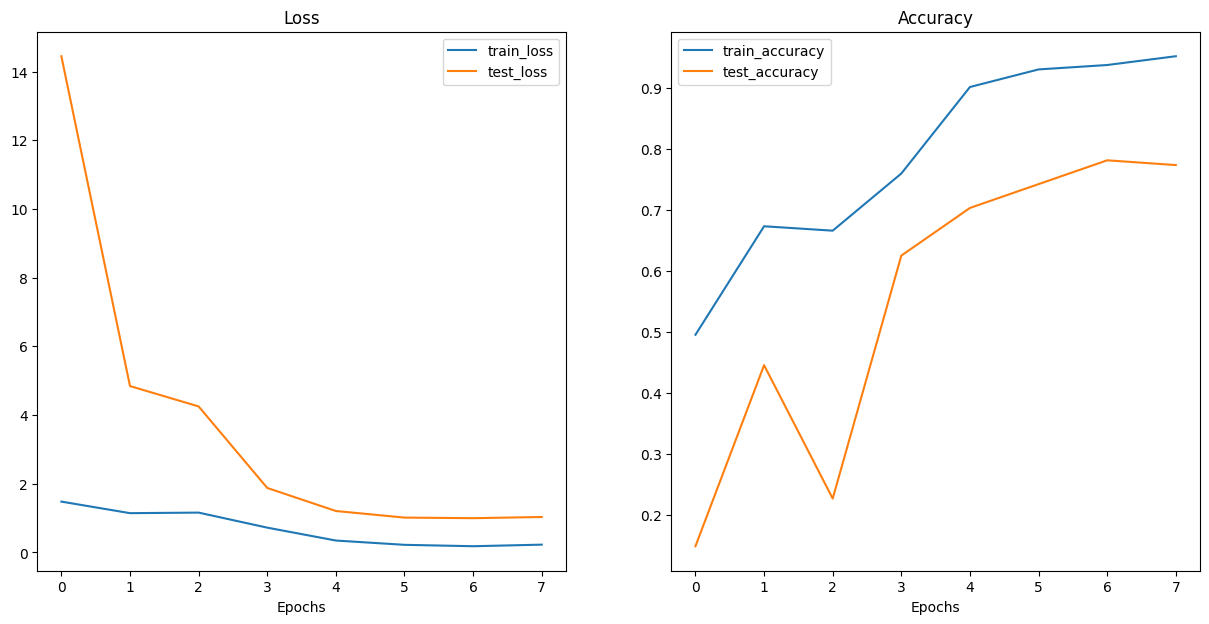

In [ ]:
# Get the loss values of the results dictionary (training and test)
loss = results['train_loss']
test_loss = results['test_loss']

# Get the accuracy values of the results dictionary (training and test)
accuracy = results['train_acc']
test_accuracy = results['test_acc']

# Figure out how many epochs there were
epochs = range(len(results['train_loss']))

# Setup a plot
plt.figure(figsize=(15, 7))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(epochs, loss, label='train_loss')
plt.plot(epochs, test_loss, label='test_loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, accuracy, label='train_accuracy')
plt.plot(epochs, test_accuracy, label='test_accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.legend();

The loss curve plots demonstrate promising results! We can clearly observe an upward trajectory in mean accuracy coupled with a downward trend in mean loss over successive epochs for both our training and test datasets. These positive indicators suggest our model is effectively learning and generalizing from our player image dataset.

To further evaluate its performance, let's visualize the model's predictions on a handful of randomly selected test images.

In [ ]:
def crop_image(img):
  """
  Crops an image to the size expected by the InceptionResnetV1 model using the MTCNN model.

  The function creates an MTCNN model configured to crop images to 160x160 pixels,
  which is the size that the InceptionResnetV1 model was trained on. It then uses the MTCNN model
  to crop the input image and returns the cropped image.

  Parameters:
  - img (PIL.Image or torch.Tensor): The input image to be cropped. Can be a PIL Image or a tensor.

  Returns:
  - torch.Tensor: The cropped image as a tensor.

  Note: The function assumes that the `device` variable is defined globally and specifies the device
  (CPU or GPU) on which the MTCNN model will run. It also removes the MTCNN model from memory after use
  to reduce GPU memory usage.
  """
  # InceptionResnetV1 was trained on 160x160 images, so that will be our "crop" size.
  IMG_SIZE = 160

  # Create MTCNN model
  mtcnn = MTCNN(
    image_size=IMG_SIZE,
    margin=0,
    thresholds=[0.6, 0.7, 0.7],
    factor=0.709,
    post_process=True,
    device=torch.device(device)
  ).to(device)

  # Open Image
  cropped_image = mtcnn(img).to(device)

  # Remove mtcnn to reduce GPU memory usage
  del mtcnn

  return cropped_image

def predict_and_plot_image(model, image, class_names: dict[int, str]):
  """
  Predicts the class of an input image using a given model and plots the image with the prediction.

  The function first crops the input image to the size expected by the model using the `crop_image` function.
  It then passes the cropped image through the model to obtain the prediction logits. These logits are
  converted to probabilities using the softmax function, and the class with the highest probability is
  selected as the predicted class.

  The input image is then plotted using matplotlib with a title that displays the predicted class name
  and the associated probability.

  Parameters:
  - model (torch.nn.Module): The neural network model used for prediction.
  - image (PIL.Image or torch.Tensor): The input image to be classified.
  - class_names (dict[int, str]): A dictionary mapping class indices to class names.

  Note: The function assumes that the `crop_image` function is defined and is used to crop the input image
  to the size expected by the model.
  """
  # Get cropped image
  img_cropped = crop_image(img)
  model.classify = True

  # Get prediction logits
  img_probs = model(img_cropped.unsqueeze(0))
  # Convert logits to probabilities (the sum of the probabilities will equal 1)
  target_image_pred_probs = torch.softmax(img_probs, dim=1)
  # Assign the highest probability as the image image label
  target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)

  # Plot Image
  plt.figure()
  plt.imshow(img)
  plt.title(f"Pred: {class_names[target_image_pred_label]} | Prob: {target_image_pred_probs.max():.3f}")
  plt.axis(False);

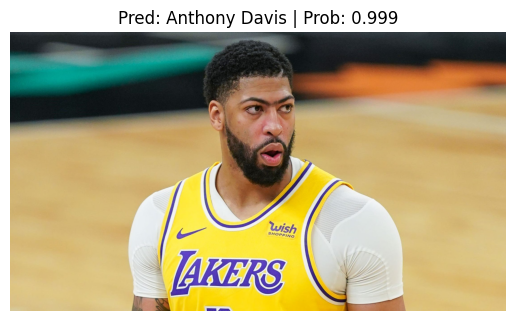

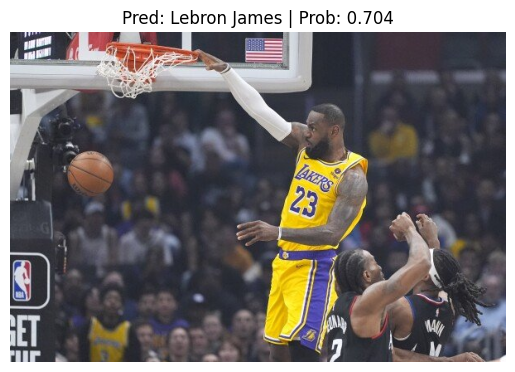

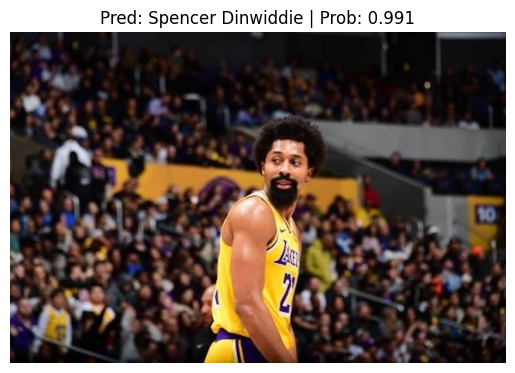

In [ ]:
# Get Sample of Random Images
k = 3
test_image_path_list = list(Path("data/lakers_players/test").glob("*/*.jpg")) # get all test image paths from 20% dataset
test_image_path_sample = random.sample(population=test_image_path_list, k=k)

for image_path in test_image_path_sample:
  img = Image.open(image_path)
  predict_and_plot_image(model, image=img, class_names=class_names)


Impressive! Our model accurately classified all three randomly selected test images. This is an extremely encouraging outcome, demonstrating the model's robust ability to generalize its learning to previously unseen data points. While we must be cautious about overinterpreting results from such a small sample size, this visual validation further reinforces the quantitative metrics suggesting our transfer learning approach yielded an effective model for this image classification task.

We appear to be on the right track for meeting our objectives! As a final test, let's feed our model a totally new image outside of our training and test data and see how it does!

data/custom_image.jpg already exists, skipping download.


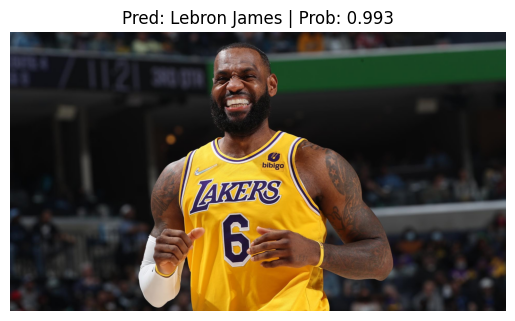

In [ ]:
# Download custom image
import requests

# Setup custom image path
custom_image_path = data_path / "custom_image.jpg"

# Download the image if it doesn't already exist
if not custom_image_path.is_file():
    with open(custom_image_path, "wb") as f:
        # When downloading from GitHub, need to use the "raw" file link
        request = requests.get("https://cdn.nba.com/manage/2020/12/lebron-james-smiles-archive.jpg")
        print(f"Downloading {custom_image_path}...")
        f.write(request.content)
else:
    print(f"{custom_image_path} already exists, skipping download.")

# Predict on custom image
img = Image.open(custom_image_path)
predict_and_plot_image(model, image=img, class_names=class_names)

## 9. Conclusion

While the results from this transfer learning experiment are promising, there are numerous opportunities to further refine and improve our model's performance. One clear area for experimentation is hyperparameter tuning and experiement tracking. Testing different learning rates, optimizers, network architectures, regularization techniques like dropout, and more could yield meaningful gains. Additionally, increasing the number of training epochs beyond the initial 8 may continue driving the accuracy higher.

Another aspect worth revisiting is the data preprocessing pipeline, specifically the MTCNN module we used for face cropping and region extraction from raw images. Instances where this step incorrectly crops background areas instead of the intended subject represent noise that could bottleneck the model, and enhancing this component of the pipeline may provide a nice accuracy uplift.

Perhaps the most tantalizing possibility, however, is radically scaling up the size of the training dataset itself. Our initial proof-of-concept used a relatively modest dataset of around 500 images, with only 40 training images for each of our 10 Laker players... but what if we aggregated thousands of NBA player images from across the web? With a massively larger and more diverse dataset, we could potentially push this model's performance to unprecedented levels, perhaps even switching from a single-label to a mutli-label classifier with the abiltiy to identify all of the NBA players included in a provided image!

I hope you enjoyed reading this post as much as I did it writing it. I'll catch you next time!



## _Appendex: Scraping Images from Google_

In [ ]:
# Time & Progress Libraries
from timeit import default_timer as timer
from tqdm.auto import tqdm
import time

# Image Library
from PIL import Image

# Scraping
import requests

# Not-Native Google Collab Libraries
try:
  !pip install selenium -q
  import selenium
  from selenium.webdriver.common.by import By
except:
  import selenium
  from selenium.webdriver.common.by import By

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.0/10.0 MB 65.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 467.2/467.2 kB 49.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 8.1 MB/s eta 0:00:00


In [ ]:
def ensure_dir_exists(directory: Path):
  """
  Ensures that the specified directory exists on the filesystem.

  If the directory already exists, it prints a message indicating that the
  directory exists and the download will be skipped. If the directory does
  not exist, it creates the directory (including any necessary parent
  directories) and prints a message indicating that the directory has been
  created.

  Parameters:
  - directory (Path): A Path object representing the directory to check or create.

  Returns:
  None
  """

  # If the image folder doesn't exist, download it and prepare it
  if directory.is_dir():
    print(f"{directory} directory already exists. Skipping Download")
  else:
    print(f"Creating {directory} directory")
    directory.mkdir(parents=True, exist_ok=True)

def download_and_save_image(url: str, parentDir: Path):
  """
  Downloads an image from a specified URL and saves it as a JPEG file in a parent directory.

  The function first attempts to download the image content from the URL. If the download
  is successful, it converts the image to RGB format and generates a unique file name based
  on the image content's SHA-1 hash. The image is then saved as a JPEG file in the specified
  parent directory with a quality of 85.

  If any errors occur during the download or saving process, the function prints an error message
  with the relevant information.

  Parameters:
  - url (str): The URL of the image to be downloaded.
  - parentDir (Path): A Path object representing the parent directory where the image file will be saved.

  Returns:
  None
  """
  try:
    image_content = requests.get(url).content
  except Exception as error:
        print(f"DOWNLOAD ERROR: {error}")

  try:
    image_file = io.BytesIO(image_content)
    image = Image.open(image_file).convert('RGB')
    file_name = f"{hashlib.sha1(image_content).hexdigest()[:5]}.jpg"
    file_path = os.path.join(parentDir, file_name)

    with open(file_path, 'wb') as f:
      image.save(f, "JPEG", quality=85)

    print(f"SUCCESS: SAVED {file_path}")
  except Exception as error:
    print(f"ERROR: {error}")

def download_player_images(image_urls: Dict[str, List[str]], train_size: float = 0.8):
  """
  Downloads player images from specified URLs and saves them in a structured directory.

  The function creates a base directory called 'data/lakers_players'. For each player in
  the 'image_urls' dictionary, it creates a subdirectory named after the player. It then
  iterates through the URLs associated with each player and downloads the images, saving
  them in the respective player's subdirectory.

  The 'ensure_dir_exists' function is used to ensure that the directories exist before
  saving the images. The 'download_and_save_image' function is used to download and save
  each image.

  Parameters:
  - image_urls (dict): A dictionary where keys are player names and values are lists of
    image URLs for that player.

  Returns:
  None
  """

  # Setup data directory
  data_path = Path('data/')
  dir_path = data_path / "lakers_players"
  ensure_dir_exists(dir_path)

  # Setup train and test directories
  train_dir = dir_path / "train"
  test_dir = dir_path / "test"
  ensure_dir_exists(train_dir)
  ensure_dir_exists(test_dir)

  for player in image_urls:
    # Create train and test player directories
    train_player_dir = train_dir / player
    test_player_dir = test_dir / player
    ensure_dir_exists(train_player_dir)
    ensure_dir_exists(test_player_dir)

    # Find train index stopping point
    split_index = round(len(image_urls[player]) * train_size)

    # Save to train directory
    for url in image_urls[player][:split_index]:
      download_and_save_image(url, train_player_dir)
    # Save to test directory
    for url in image_urls[player][split_index:]:
      download_and_save_image(url, test_player_dir)

def fetch_google_images(queries: List[str], limit: int) -> Dict[str, List[str]]:
  """
  Fetches a specified number of image URLs for each query from Google Images.

  The function instantiates a headless Selenium WebDriver to navigate Google Images and
  fetches the URLs of the first 'limit' images for each query in the 'queries' list. It
  scrolls the page to load more images and clicks on thumbnails to access the full-size
  image URLs. The URLs are collected in a dictionary where each key is a query and the
  value is a list of image URLs for that query.

  Parameters:
  - queries (list): A list of strings representing search queries.
  - limit (int): The maximum number of image URLs to fetch for each query.

  Returns:
  dict: A dictionary where keys are queries and values are lists of image URLs.
  """

  # Instantiate selenum webdriver
  options = selenium.webdriver.ChromeOptions()
  options.add_argument('headless')
  options.add_argument('--disable-infobars')
  options.add_argument('--disable-dev-shm-usage')
  options.add_argument('--no-sandbox')
  options.add_argument('--remote-debugging-port=9222')
  driver = selenium.webdriver.Chrome(options=options)

  # Dictionary to be returned
  image_urls = {}

  for query in tqdm(queries):
    print(f"Fetching Images for: {query}")
    driver.get(f"https://www.google.com/search?tbm=isch&q={query}&oq={query}")
    driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
    time.sleep(1)

    # First, grab image thumbnails
    image_thumbnails = driver.find_elements(By.CSS_SELECTOR, 'a.FRuiCf')
    urls = []
    pbar = tqdm(total=limit)

    for image in image_thumbnails:
      image.click()
      time.sleep(2)

      try:
        image_url = driver.find_element(By.CSS_SELECTOR, 'img.iPVvYb[src*="https"]')
        urls.append(image_url.get_attribute('src'))
        pbar.update(1)
      except Exception as error:
        # Handle exception by skipping the current image
        continue

      # If the number of captured image urls equals provided limit, break loop
      if len(urls) == limit:
        pbar.close()
        break

    image_urls[query] = urls

  # Close webdriver gracefully
  driver.quit()

  return image_urls

In [ ]:
# List of queries to search Google Images for.
queries_to_search = [
    "Lebron James",
    "Anthony Davis",
    "Rui Hachimura",
    "Austin Reaves",
    "D'Angelo Russell",
    "Tauraen Prince",
    "Spencer Dinwiddie",
    "Jaxson Hayes",
    "Christian Wood",
    "Max Christie"
]

# If images folder already exists, skip scraping.
if Path('data/lakers_players').is_dir():
  print(f"Images already downloded.")
else:
  start_time = timer()
  urls = fetch_google_images(queries_to_search, limit=50)
  download_player_images(urls)
  total_time = ((timer() - start_time) / 60)
  print(f"Images successfully downloaded in {total_time} minutes")


NameError: name 'Path' is not defined